In [8]:
"""
Created on Wed Aug  4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from main import *
debug_mode = True  # faster experiments for debugging

# util for getting objects' fields' names
field_names = lambda x: list(vars(x).keys())

In [3]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
"""
bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
dm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'],
                       experimentSettings['ipscaler'], experimentSettings['opscaler'])
dm.input_data_cols
"""

"\nbestModel, experimentSettings = exprExec.modelFactory.openBestModel()\ndm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'],\n                       experimentSettings['ipscaler'], experimentSettings['opscaler'])\ndm.input_data_cols\n"

In [4]:
'''
Run the Model Experiments
'''

"""
model = 'PCDNN_V2'
assert model in ['PCDNN_V2', 'PCDNN_V1', 'SIMPLE_DNN', 'GP'] # valid possible models
exprExec=run_model_experiments(dm, models=model, debug_mode=debug_mode)
"""
exprExec = run_pcdnn_v2_experiments(dm, use_dependants=True, debug_mode = debug_mode)

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated
=================== randomequalflamesplit ===================
------------------ AllSpecies ------------------
--------------------self.build_and_compile_pcdnn_v2_model----------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7309, 3217, 13527, 14989, 4849, 9944, 11018, 8974, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 29198, 12208, 3752, 14239, 2620]
test_set_keys:  [2246, 2758, 3056, 2364, 21463, 2027, 4376, 2903, 26352, 30735, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 7694, 6597, 5104, 22593, 4606]
train:  [ 3752 11018  3217  2620 25034]
test:  [ 2903 11598 27738  5104  4157]
53 4 N Y Y Y
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 53)]              0         
                                            

ValueError: Wrong number of items passed 9, placement implies 1

In [5]:
""" prepare SimpleDNN for loading (from prior experiments) """

exprExec = DNNExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(SimpleDNNModelFactory())

Parent DNNModelFactory Instantiated


In [6]:
""" prepare PCDNNV1 for loading (from prior experiments) """

exprExec = PCDNNV1ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV1ModelFactory())

Parent DNNModelFactory Instantiated


In [4]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [8]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dataSetMethod = f'{inputType}_{dataType}'
opscaler = "MinMaxScaler"# 'PositiveLogNormal'
ZmixPresent = 'Y'
concatenateZmix = 'Y'
kernel_constraint = 'Y'
kernel_regularizer = 'Y'
activity_regularizer = 'Y'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='relu'
exprExec.modelFactory.dropout_rate=0.5
exprExec.debug_mode = False
exprExec.epochs_override = 5
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                 noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                 kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                 opscaler=opscaler)

--------------------self.build_and_compile_pcdnn_v2_model----------------------
53 4 Y Y Y
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 linear_embedding (Functional)  (None, 4)            216         ['species_input[0][0]']          
                                                                                                  
 concatenated_zmix_linear_embed  (None, 5)           0           ['zmix[0][0]',                   
 

129/129 [==============================] - 6s 28ms/step - loss: 1.1218 - mae: 1.0078 - mse: 1.8393 - exp_mse_mag: 1.4808 - exp_mae_mag: 0.3420 - exp_R2: -29697.6934 - R2: -132.8647 - val_loss: 0.1476 - val_mae: 0.1452 - val_mse: 0.0282 - val_exp_mse_mag: -1.3489 - val_exp_mae_mag: -0.7709 - val_exp_R2: -0.5262 - val_R2: -0.7601
Epoch 2/5
129/129 [==============================] - 3s 25ms/step - loss: 0.4537 - mae: 0.4513 - mse: 0.3904 - exp_mse_mag: 0.0054 - exp_mae_mag: -0.2482 - exp_R2: -102.9499 - R2: -28.6104 - val_loss: 0.0673 - val_mae: 0.0647 - val_mse: 0.0208 - val_exp_mse_mag: -1.4833 - val_exp_mae_mag: -1.1148 - val_exp_R2: -0.0239 - val_R2: -0.0119
Epoch 3/5
129/129 [==============================] - 3s 25ms/step - loss: 0.1797 - mae: 0.1765 - mse: 0.0751 - exp_mse_mag: -0.9596 - exp_mae_mag: -0.7054 - exp_R2: -19.4124 - R2: -4.7097 - val_loss: 0.1012 - val_mae: 0.0965 - val_mse: 0.0289 - val_exp_mse_mag: -1.3597 - val_exp_mae_mag: -0.9617 - val_exp_R2: -0.3738 - val_R2: -0.

NameError: name 'single_experiment' is not defined

## Results Plotting & Analysis

In [ ]:
loss = 727684307.3417714 # Update Me!

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")
print_scientific_notation(loss)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.maximum(history.history['val_R2'][30:], 0))
plt.title('val_R^2 vs epochs')
plt.ylabel('percent')
plt.xlabel('epochs')
plt.show()

In [5]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)

train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7309, 3217, 13527, 14989, 4849, 9944, 11018, 8974, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 29198, 12208, 3752, 14239, 2620]
test_set_keys:  [2246, 2758, 3056, 2364, 21463, 2027, 4376, 2903, 26352, 30735, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 7694, 6597, 5104, 22593, 4606]
train:  [ 3752 11018  3217  2620 25034]
test:  [ 2903 11598 27738  5104  4157]

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequalflamesplit_AllDependants', 'ipscaler': 'MinMaxScaler', 'opscaler': 'MinMaxScaler', 'noOfCpv': 4, 'ZmixPresent': 'N', 'concatenateZmix': 'N', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'Y', 'input_data_cols': ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', '

cpv4; 2.513391e-03 +/- 5.558616e-05
cpv2; 9.354915e-04 +/- 1.507638e-05
cpv1; 3.659453e-04 +/- 1.848681e-05
cpv3; -5.510950e-05 +/- 5.098536e-06
zmix; -1.170035e-04 +/- 2.507310e-05


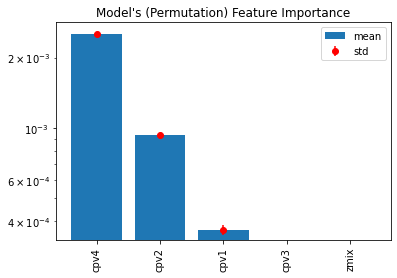

In [10]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

         zmix      cpv1      cpv2      cpv3      cpv4
min  0.000000 -0.550150 -0.670431 -0.457964 -1.137624
25%  0.213436  0.029801 -0.407500 -0.023284 -0.162101
50%  0.402179  0.158562 -0.243002  0.002826 -0.086248
75%  0.639781  0.287660 -0.121952  0.045799 -0.008506
max  1.000000  0.582263  0.255201  0.261311  0.758503


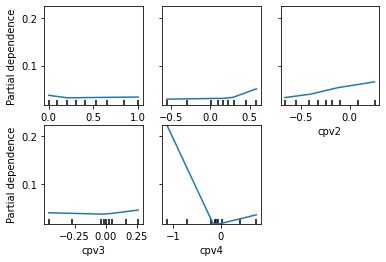

In [11]:
inspector.plot_partial_dependence()

In [6]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['actual'] = Y_test.flatten()

    evaluation_df_1['prediction'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['actual'] - evaluation_df_1['prediction']
   
    return evaluation_df_1['res'].values

#### Error Density by FlameId & XPos

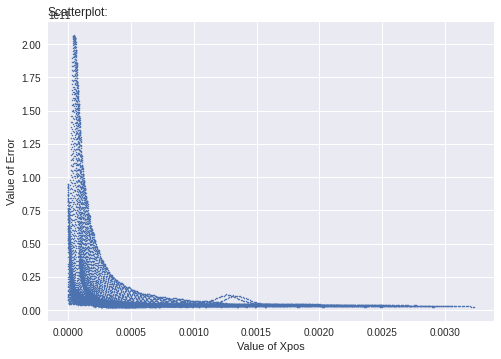

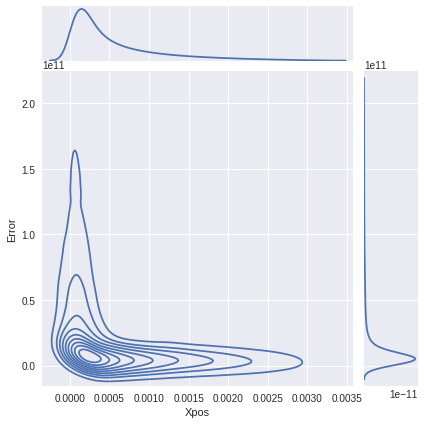

In [29]:
# TODO: Sanity check that this plots output ranges are correct? Seems like bug!

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X,Y,rom,Zmix = dm.getAllData()
#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData()
Y_test = Y
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, 0]
souener_test = opscaler.inverse_transform(Y_test)[:, 0]

#residual/error

residuals = getResiduals(souener_test,souener_pred)

Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot( 'Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')

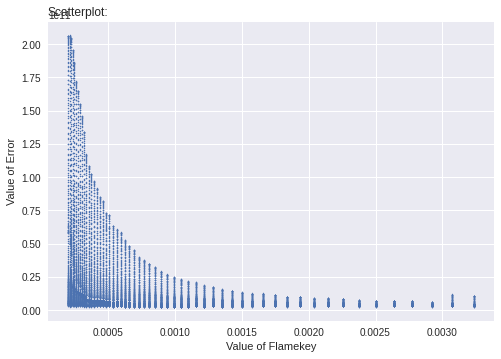

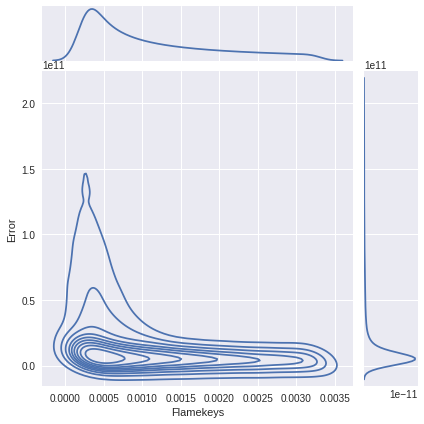

In [30]:
#residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = df['flame_key']#np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

(array([13864.,   988.,   538.,   334.,   210.,   127.,   109.,   103.,
           79.,    92.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

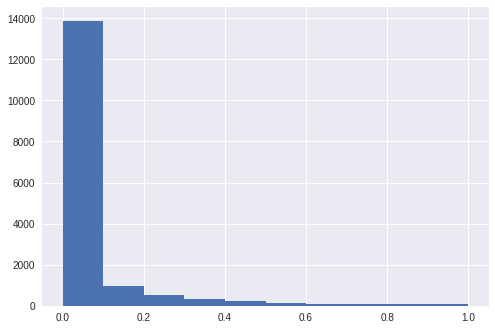

In [36]:
plt.hist(Y_test[:,0])

(array([  80.,  140.,  189.,  301.,  290.,  568., 2393., 3826., 5348.,
        3309.]),
 array([-3.3910751e-02, -3.0515013e-02, -2.7119275e-02, -2.3723535e-02,
        -2.0327797e-02, -1.6932059e-02, -1.3536321e-02, -1.0140582e-02,
        -6.7448439e-03, -3.3491054e-03,  4.6633202e-05], dtype=float32),
 <BarContainer object of 10 artists>)

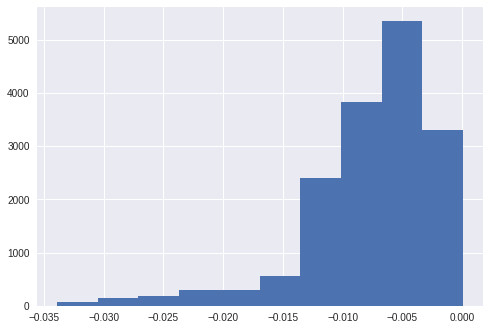

In [35]:
plt.hist(Y_pred[:,0])